# Deep Learning  Project


In [ ]:
# Required installations
!pip install transformers sentence-transformers faiss-cpu torch numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 18.5 MB/s eta 0:00:00


## Huggingface Access Token

How to get & prepare HF_TOKEN:
1. Log in to huggingface
2. Create a token here: https://huggingface.co/settings/tokens (Read-Only)
3. Copy the Value from there. Ek dafa aayegi sirf.
4. You need to click on the key icon to the left and place your token there under the name 'HF_TOKEN'. Name and Value as it is written on the Hugging Face Website
5. Allow access for that token to this notebook

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import torch
from sentence_transformers import SentenceTransformer
import faiss
import json
import numpy as np
import pickle
import os

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# Define paths for Google Drive
DRIVE_PATH = "/content/drive/MyDrive/DLProject"  # Base folder in Drive
DATA_PATH = os.path.join(DRIVE_PATH, "qa_data.json")
INDEX_PATH = os.path.join(DRIVE_PATH, "qa_faiss_index.index")
PROCESSED_DATA_PATH = os.path.join(DRIVE_PATH, "processed_data.pkl")

# Create directory if it doesn't exist
os.makedirs(DRIVE_PATH, exist_ok=True)

In [ ]:
# Initialize embedding model
embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embedding_dim = 384  # MiniLM embedding dimension: 384 is not an arbitrary number. It's the output dimension of the chosen sentence transformer model.
print("Embedding model Loaded")
# Initialize FAISS index
index = faiss.IndexFlatL2(embedding_dim)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model Loaded


In [ ]:
# Load data
with open(DATA_PATH, 'r') as f:
    qa_data = json.load(f)
print("QA Data Loaded Successfully")

QA Data Loaded Successfully


In [ ]:
# Parse into Answer and Questions
documents = [item['answer'] for item in qa_data]
questions = [item['question'] for item in qa_data]
print(questions)
print(documents)


['Which office handles class schedules and course enrollment at Habib University?', 'What should I do if I have a problem with my class schedule?', "Where is the Registrar's Office located at Habib University?", 'How can I resolve issues with my course schedule if I can’t visit the Registrar’s Office?', 'How do I contact the Registrar’s Office for general inquiries?', 'How can I access the end term examination schedule?', 'Can the end term examination schedule be changed if there are two major course exams on a single day?', 'Can I get an unofficial version of my transcript?', 'How long will it take the transcript to be processed?', 'Can someone else pick up my transcript on my behalf?', 'How can I view my end term examination answer book?', 'How can I submit a grievance on a checked end term examination answer book/copy?', 'How can I access my Self-Service enrolment in PeopleSoft?', 'How can I audit a course?', 'What is the process for enrolling in a course where the instructor’s perm

In [ ]:
# Function to process documents in batches
def process_documents_in_batches(docs, batch_size=32):
    all_embeddings = []
    # Iterate through the documents in batches.
    for i in range(0, len(docs), batch_size):
        batch = docs[i:i + batch_size] # Get the current batch of documents.
        print(f"Processing batch {i//batch_size + 1}/{len(docs)//batch_size + 1}") # Current Batch / Total No of Batches
        embeddings = embeddings_model.encode(batch, convert_to_tensor=True) # Generate embeddings for the current batch using the pre-loaded embeddings_model.
        embeddings = embeddings.cpu().numpy() # Move embeddings to CPU and convert to NumPy array.
        # ensures they can be used with other libraries or functions that may not be GPU-compatible.
        all_embeddings.append(embeddings) # Append the batch embeddings to the list of all embeddings.
    return np.vstack(all_embeddings) # Vertically stack all batch embeddings into a single NumPy array.

In [ ]:
# Generate embeddings
print("Generating embeddings...")
document_embeddings = process_documents_in_batches(documents)

Generating embeddings...
Processing batch 1/23
Processing batch 2/23
Processing batch 3/23
Processing batch 4/23
Processing batch 5/23
Processing batch 6/23
Processing batch 7/23
Processing batch 8/23
Processing batch 9/23
Processing batch 10/23
Processing batch 11/23
Processing batch 12/23
Processing batch 13/23
Processing batch 14/23
Processing batch 15/23
Processing batch 16/23
Processing batch 17/23
Processing batch 18/23
Processing batch 19/23
Processing batch 20/23
Processing batch 21/23
Processing batch 22/23
Processing batch 23/23


In [ ]:
# Add to FAISS index
index.add(document_embeddings)
print("Embeddings to FAISS index Added")

Embeddings to FAISS index Added


In [ ]:
# Save the FAISS index
faiss.write_index(index, INDEX_PATH)
print("FAISS index Saved")

FAISS index Saved


In [ ]:
# Save documents and questions for later use
with open(PROCESSED_DATA_PATH, 'wb') as f:
    pickle.dump({
        'documents': documents,
        'questions': questions
    }, f)

print(" QNA .PKL saved!")

 QNA .PKL saved!


In [ ]:
print("\nTesting:")
test_index = faiss.read_index(INDEX_PATH)
test_question = "Where is the Registrar's Office?"
test_embedding = embeddings_model.encode([test_question])
# The main Asusmption here is that Question Embedding would be Semantically Similar to its Answer Embedding (Good Enough Assumption for Top K Retrieval)
D, I = test_index.search(test_embedding, k=3)

print("\nTest Question:", test_question)
print("\nTop 3 most relevant Answers (AKA Documents):")

for i, idx in enumerate(I[0]):
    print(f"\nAnswer {i+1} (Distance: {D[0][i]:.4f}):")
    print(questions[idx])
    print(documents[idx])


Testing:

Test Question: Where is the Registrar's Office?

Top 3 most relevant Answers (AKA Documents):

Answer 1 (Distance: 0.8322):
Where is the Registrar's Office located at Habib University?
The Registrar's Office is located in the Student Center at Habib University. You can visit them in person if you face any issues related to class schedules or enrollment.

Answer 2 (Distance: 0.9967):
What should I do if I want to change my academic major?
Submit a Change of Program/School Request Form to the Office of Academic Systems & Registrar.

Answer 3 (Distance: 1.1936):
How do I contact the Registrar’s Office for general inquiries?
You can contact the Registrar's Office either by visiting their office in the Student Center or by sending an email to registrar-office@habib.edu.pk for any inquiries related to course schedules, enrollment, or other academic concerns.


In [ ]:
def evaluate_retrieval(retrieved_indices, relevant_indices):
  """Evaluates retrieval performance using Recall@k, Precision@k, MRR, and NDCG.

  Args:
    retrieved_indices: A list of lists, where each sublist contains the indices of
      retrieved documents for a query.
    relevant_indices: A list of lists, where each sublist contains the indices of
      relevant documents for a query.

  Returns:
    A dictionary containing the evaluation metrics.
  """

  k_values = [1, 3, 5, 10]  # Evaluate at different values of k
  metrics = {
      'Recall@k': {k: [] for k in k_values},
      'Precision@k': {k: [] for k in k_values},
      'F1': {k: [] for k in k_values},
      'MRR': [],
      'NDCG': []
  }

  for i, retrieved in enumerate(retrieved_indices):
    relevant = relevant_indices[i]

    for k in k_values:
      retrieved_k = retrieved[:k]
      num_relevant_retrieved = len(set(retrieved_k) & set(relevant))

      # Recall@k
      recall = num_relevant_retrieved / len(relevant) if len(relevant) > 0 else 1.0  # Avoid division by zero
      metrics['Recall@k'][k].append(np.round(recall,2))

      # Precision@k
      precision = num_relevant_retrieved / k if k > 0 else 1.0  # Avoid division by zero
      metrics['Precision@k'][k].append(np.round(precision,2))

      #F1

      if recall + precision > 0:
        f1 = 2 * (recall * precision) / (recall + precision)
        metrics['F1'][k].append(np.round(f1,2))

    # MRR
    rank_first_relevant = next((i + 1 for i, doc_id in enumerate(retrieved) if doc_id in relevant), 0)
    mrr = 1.0 / rank_first_relevant if rank_first_relevant > 0 else 0.0
    metrics['MRR'].append(np.round(mrr,2))

    # NDCG (Simplified calculation for binary relevance)
    dcg = sum([1.0 / np.log2(i + 2) for i, doc_id in enumerate(retrieved) if doc_id in relevant])
    ideal_dcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(relevant), len(retrieved)))])
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0.0
    metrics['NDCG'].append(np.round(ndcg,2))

  # Average metrics across all queries
  for metric in metrics:
    if metric != 'Recall@k' and metric != 'Precision@k' and metric != 'F1':
      metrics[metric] = np.mean(metrics[metric])
    else:
      for k in k_values:
        metrics[metric][k] = np.mean(metrics[metric][k])
  return metrics

# Function to generate retrieved indices for a batch of queries
def get_retrieved_indices(queries, index, top_k=10):
  """Generates retrieved indices for a batch of queries using FAISS index."""
  query_embeddings = embeddings_model.encode(queries, convert_to_tensor=True)
  query_embeddings = query_embeddings.cpu().numpy()
  D, I = index.search(query_embeddings, k=top_k)  # Search the index
  return I  # Return the retrieved indices

# Get retrieved indices for all questions in your dataset
retrieved_indices = get_retrieved_indices(questions, index, top_k=10)

# Generate relevant indices (assuming a question is relevant to its own answer)
relevant_indices = [[i] for i in range(len(questions))]

evaluation_results = evaluate_retrieval(retrieved_indices, relevant_indices)
print(evaluation_results)  # Print the evaluation metrics

{'Recall@k': {1: 0.6133879781420765, 3: 0.7773224043715847, 5: 0.8415300546448088, 10: 0.894808743169399}, 'Precision@k': {1: 0.6133879781420765, 3: 0.25651639344262295, 5: 0.16830601092896175, 10: 0.08948087431693987}, 'F1': {1: 1.0, 3: 0.5, 5: 0.33000000000000007, 10: 0.17999999999999997}, 'MRR': 0.708948087431694, 'NDCG': 0.754275956284153}


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Extract Recall@k and Precision@k values from evaluation_results
recall_data = evaluation_results['Recall@k']
precision_data = evaluation_results['Precision@k']
f1_data = evaluation_results['F1']

# Create a Pandas DataFrame for the heatmap
data = pd.DataFrame({
    'k': list(recall_data.keys()),
    'Recall@k': list(recall_data.values()),
    'Precision@k': list(precision_data.values()),
    'F1': list(f1_data.values())
})

# Reshape the data for heatmap
data = data.melt(id_vars=['k'], var_name='Metric', value_name='Value')

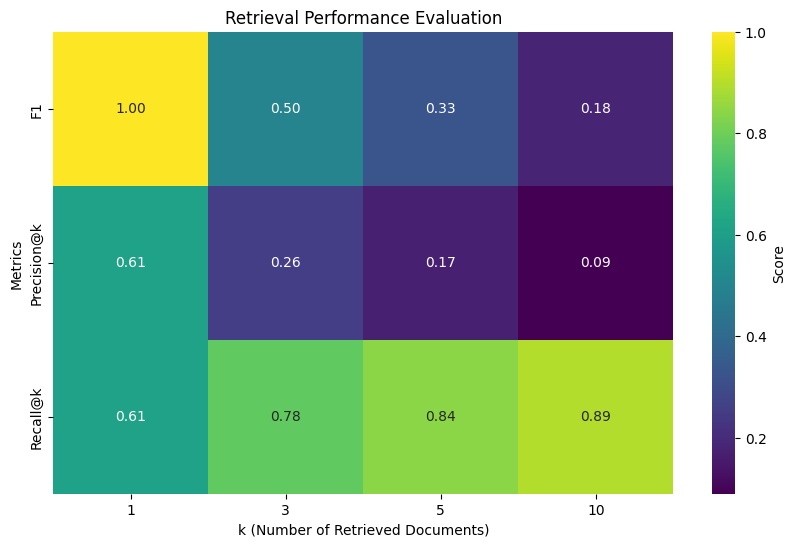

In [ ]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(
    data.pivot(index='Metric', columns='k', values='Value'), # Use keyword arguments for index, columns, and values
    annot=True,
    cmap='viridis',
    fmt=".2f",
    cbar_kws={'label': 'Score'}
)
plt.title('Retrieval Performance Evaluation')
plt.xlabel('k (Number of Retrieved Documents)')
plt.ylabel('Metrics')
plt.show()

### K = 3 or K = 5 seem like an ideal balance!

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets